## 5.4-1-visualizing-object using Grad-CAM

(1) 다른 Object에 대하여 Heatmap을 이용하여 활성화된 Class를 시각화(using Grad-CAM(Class Activation Map))를 실행해본 예제 임

(2) MS windows에 포함되어 있는 코알라, 수국 image로 수행하였음

In [15]:
import keras
keras.__version__

'2.3.1'

In [2]:
from keras.applications.vgg16 import VGG16
from keras import backend as K
from matplotlib import pyplot as plt

K.clear_session()

# 지금까지는 상단의 Fully Connected Network는 제외하고 model을 생성했으나, 금번에는 모두 포함
model = VGG16(weights='imagenet')

## (1) Koala (코알라)

In [3]:
# 해당 koala image를 VGG16 모델이 인식 할 수 있도록 다음의 전처리를 통해 변환 (크기 변환, 숫자 Type 변환)

from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = './image/datasets/koala.jpg'

# 224 × 224 인 PIL(Python Image Labrary) image객체로 변환
img = image.load_img(img_path, target_size=(224, 224))

# 해당 image 객체를 (224 * 224 * 3) 인  numpy 텐서로 변환
x = image.img_to_array(img)

# VGG16에 주입하기 위해  차원을 추가하여 (1 *224 * 224 * 3) 텐서로 변환
x = np.expand_dims(x, axis=0)

# keras.applications.vgg16.preprocess_input Method를 이용하여 전처리 (Channel 별 Color 정규화)
x = preprocess_input(x)

In [4]:
# VGG16 모델 주입 후, 다음과 같이 거의 100% 확률로 koala 일 가능성이 가장 높게 나타났음

preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=5)[0])


Predicted: [('n01882714', 'koala', 0.99999), ('n01883070', 'wombat', 5.2117684e-06), ('n01877812', 'wallaby', 2.6965424e-06), ('n02497673', 'Madagascar_cat', 1.0782513e-06), ('n02500267', 'indri', 5.7338883e-07)]


In [5]:
# VGG16 모델 주입 후 최종 결과 vector에서 최대 활성화 index를 확인
# 최종 결과 Vector는 VGG16으로 예측한 10000개 Object에 대한 일치 확률 임
np.argmax(preds[0])

105

In [6]:
# Grad-CAM(Class Activaton Map) 처리 과정

# African Elephant
african_elephant_output = model.output[:, 105]

# VGG16의 마지막 Convolution Layer인 block5_conv3 layer의 feature map
last_conv_layer = model.get_layer('block5_conv3')

# block5_conv3의 feature map 출력에 대한 African Elephant class의 gradient
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# feature map channel 별 gradient 평균 값이 담긴 vector
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# Sample image가 주어졌을 때  pooled_grads와 block5_conv3의 feature map 출력 구하기
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# 해당 elephant sample image를 주입하고 2개의 numpy array를 받음
pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# 해당 feature map에서 channel axis를 따라 평균한 값이 class activaton heat map
heatmap = np.mean(conv_layer_output_value, axis=-1)

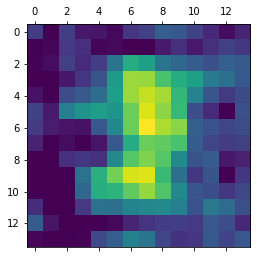

In [7]:
# Heatmap을 0~1 사이 값으로 정규화한 최종 결과
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [8]:
# OpenCV를 사용해 heat map에 원본 image를 겹쳐 새로운 image 생성

import cv2

# cv2 모듈을 사용해 원본 이미지를 로드
img = cv2.imread(img_path)

# heatmap을 원본 이미지 크기에 맞게 변경
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# heatmap을 RGB 포맷으로 변환
heatmap = np.uint8(255 * heatmap)

# 히트맵으로 변환
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4는 히트맵의 강도
superimposed_img = heatmap * 0.4 + img

# 디스크에 이미지를 저장
cv2.imwrite('./image/datasets/koala_cam.jpg', superimposed_img)

True

![elephant cam](./image/datasets/koala_cam.jpg)

해당 Network(VGG16)에서는 100%의 확률로 코알라로 인지하였고, 붉은 색으로 변환된 코와 미간을 식별하여 인지 했을 것으로 판단 됨
 - 100% : koala
 - 0%     : wombat
 - 0%     : wallaby
 - 0%     : Madagascar cat
 - 0%    : indri

![koala](./image/datasets/koala.jpg)

## (2) hydrangeas (수국)

In [9]:
# 해당 image를 VGG16 모델이 인식 할 수 있도록 다음의 전처리를 통해 변환 (크기 변환, 숫자 Type 변환)

from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = './image/datasets/hydrangeas.jpg'

# 224 × 224 인 PIL(Python Image Labrary) image객체로 변환
img = image.load_img(img_path, target_size=(224, 224))

# 해당 image 객체를 (224 * 224 * 3) 인  numpy 텐서로 변환
x = image.img_to_array(img)

# VGG16에 주입하기 위해  차원을 추가하여 (1 *224 * 224 * 3) 텐서로 변환
x = np.expand_dims(x, axis=0)

# keras.applications.vgg16.preprocess_input Method를 이용하여 전처리 (Channel 별 Color 정규화)
x = preprocess_input(x)

In [10]:
# VGG16 Model에 주입

preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=5)[0])

Predicted: [('n07716358', 'zucchini', 0.20848839), ('n07718472', 'cucumber', 0.14579606), ('n03991062', 'pot', 0.12804578), ('n07714571', 'head_cabbage', 0.12721713), ('n12768682', 'buckeye', 0.08243804)]


In [11]:
# VGG16 모델 주입 후 최종 결과 vector에서 최대 활성화 index를 확인
# 최종 결과 Vector는 VGG16으로 예측한 10000개 Object에 대한 일치 확률 임
np.argmax(preds[0])

939

In [12]:
# Grad-CAM(Class Activaton Map) 처리 과정

# African Elephant
african_elephant_output = model.output[:, 939]

# VGG16의 마지막 Convolution Layer인 block5_conv3 layer의 feature map
last_conv_layer = model.get_layer('block5_conv3')

# block5_conv3의 feature map 출력에 대한 African Elephant class의 gradient
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# feature map channel 별 gradient 평균 값이 담긴 vector
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# Sample image가 주어졌을 때  pooled_grads와 block5_conv3의 feature map 출력 구하기
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# 해당 elephant sample image를 주입하고 2개의 numpy array를 받음
pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# 해당 feature map에서 channel axis를 따라 평균한 값이 class activaton heat map
heatmap = np.mean(conv_layer_output_value, axis=-1)

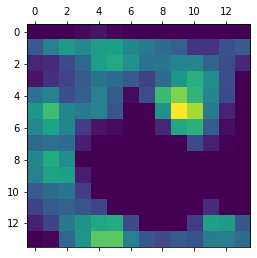

In [13]:
# Heatmap을 0~1 사이 값으로 정규화한 최종 결과
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [14]:
# OpenCV를 사용해 heat map에 원본 image를 겹쳐 새로운 image 생성

import cv2

# cv2 모듈을 사용해 원본 이미지를 로드
img = cv2.imread(img_path)

# heatmap을 원본 이미지 크기에 맞게 변경
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# heatmap을 RGB 포맷으로 변환
heatmap = np.uint8(255 * heatmap)

# 히트맵으로 변환
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4는 히트맵의 강도
superimposed_img = heatmap * 0.4 + img

# 디스크에 이미지를 저장
cv2.imwrite('./image/datasets/hydrangeas_cam.jpg', superimposed_img)

True

![elephant cam](./image/datasets/hydrangeas_cam.jpg)

위의 사진과 같이, 해당 Network(VGG16)에서는 붉은색으로 변환된 수국의 꽃과 잎을 식별하여 Object를 인지하고자 하였으나, 결과는 다음과 같음<br>
수국(hydrangeas)이 training 대상 image에 포함되어 있지 않아, training 하지 않았을 것으로 예상 함

- 21% : zucchini (주키니(오이 비슷한 서양호박)) 
- 15% : cucumber (오이)
- 13% : pot (솥, 냄비)
- 13% : head cabbage (양배추)
- 8% : buckeye (칠엽수 나무)

![hydrangeas](./image/datasets/hydrangeas.jpg)